In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RadiusGraph


In [2]:
#  LOAD THE DATACUBES OF THE GRID FROM C PORTA CODE
datadir = '../../data_porta'
# ---- grid dimensions taken from the C code ----
nx = ny = 504
nz = 476 - 52 + 1          # 425
nlev = 6                   # caii[0] … caii[5]

# ---- memory–mapped array: reads only the chunks you touch ----
pops = np.memmap(
    f'{datadir}/AR_385_CaII_5L_pops.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, nlev)   # (k, j, i, level)==(z, y, x, L)
)

# ---- memory–mapped array: reads only the chunks you touch ----
b_xyz = np.memmap(
    f'{datadir}/AR_385_B.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 3)   # (k, j, i, B_i)==(z, y, x, B)
)

# ---- memory–mapped array: reads only the chunks you touch ----
temp = np.memmap(
    f'{datadir}/AR_385_temp.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
vel = np.memmap(
    f'{datadir}/AR_385_veloc.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 3)   # (k, j, i, 3)==(z, y, x, 3)
)

# ---- memory–mapped array: reads only the chunks you touch ----
n_e = np.memmap(
    f'{datadir}/AR_385_ne.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
n_p = np.memmap(
    f'{datadir}/AR_385_np.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
n_h = np.memmap(
    f'{datadir}/AR_385_nh.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
# geom = np.memmap(
#     f'{datadir}/AR_385_GEOMETRY.dat',
#     dtype='<f4',           # little-endian 32-bit float
#     mode='r',
#     shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
# )

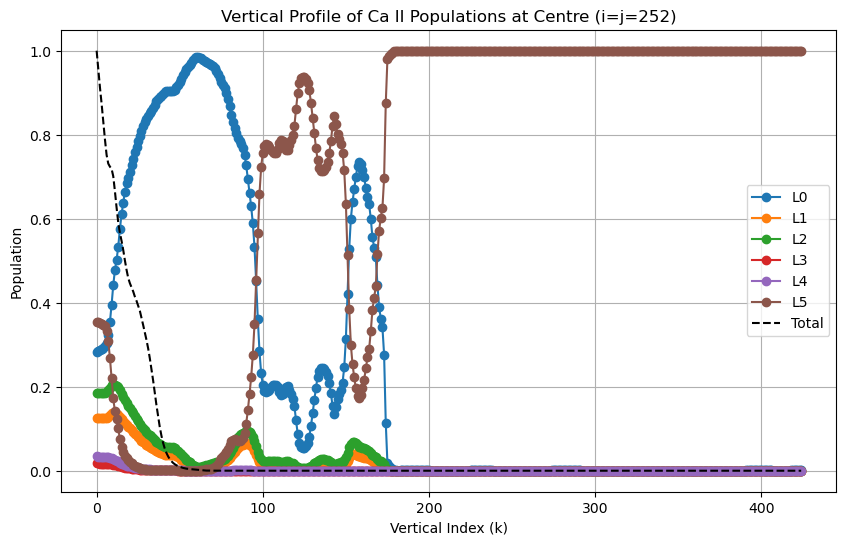

In [3]:
# example: vertical profile through the centre (i=j=252)
central_column = pops[:, 252, 252, :6]  # shape (425, 5)  – only the 5 useful levels
total_population = np.sum(central_column, axis=1)

# plot the central column populations
plt.figure(figsize=(10, 6))
plt.plot(central_column[:, 0]/total_population, label='L0', marker='o')
plt.plot(central_column[:, 1]/total_population, label='L1', marker='o')
plt.plot(central_column[:, 2]/total_population, label='L2', marker='o')
plt.plot(central_column[:, 3]/total_population, label='L3', marker='o')
plt.plot(central_column[:, 4]/total_population, label='L4', marker='o')
plt.plot(central_column[:, 5]/total_population, label='L5', marker='o')
plt.plot(total_population/np.max(total_population), label='Total', linestyle='--', color='black')
plt.title('Vertical Profile of Ca II Populations at Centre (i=j=252)')
plt.xlabel('Vertical Index (k)')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.show()

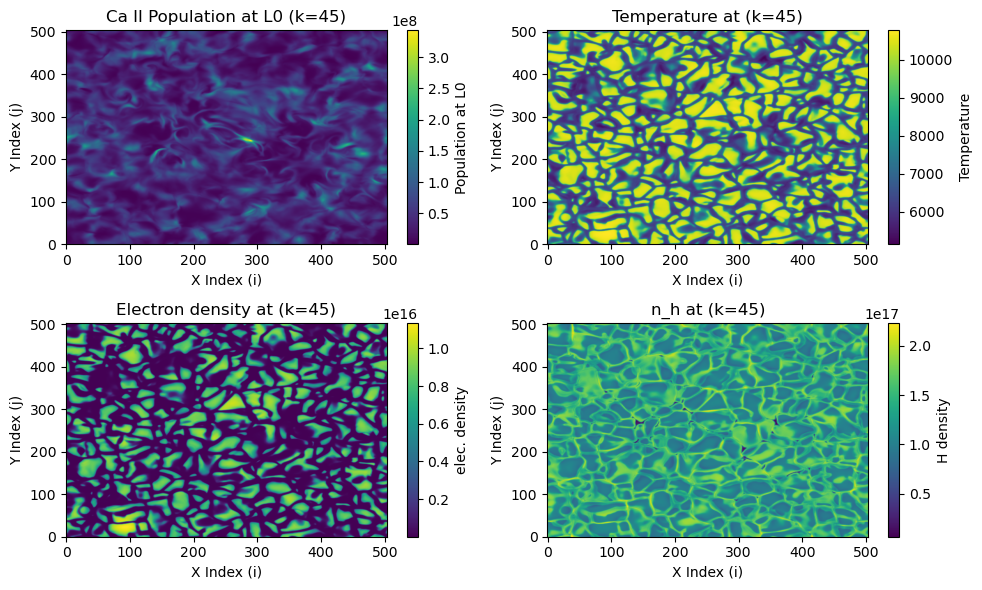

In [4]:
# plot the plane at a fixed vertical index (k=252)
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.imshow(pops[80, :, :, 0], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Population at L0')
plt.title('Ca II Population at L0 (k=45)')
plt.xlabel('X Index (i)')
plt.ylabel('Y Index (j)')

plt.subplot(222)
plt.imshow(temp[80, :, :, 0], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Temperature')
plt.title('Temperature at (k=45)')
plt.xlabel('X Index (i)')
plt.ylabel('Y Index (j)')

plt.subplot(223)
plt.imshow(n_e[80, :, :, 0], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='elec. density')
plt.title('Electron density at (k=45)')
plt.xlabel('X Index (i)')
plt.ylabel('Y Index (j)')

plt.subplot(224)
plt.imshow(n_h[80, :, :, 0], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='H density')
plt.title('n_h at (k=45)')
plt.xlabel('X Index (i)')
plt.ylabel('Y Index (j)')

plt.tight_layout()
plt.show()

In [5]:
# ---- create a grid of x, y, z coordinates ----
def create_grid(nz: int, ny: int, nx: int):
    """Creates a 3D grid of points."""
    x = np.linspace(0, nx - 1, nx)
    y = np.linspace(0, ny - 1, ny)
    z = np.linspace(0, nz - 1, nz)
    zv, yv, xv = np.meshgrid(z, y, x, indexing='ij')
    grid = np.stack([zv.ravel(), yv.ravel(), xv.ravel()], axis=1)
    return torch.tensor(grid, dtype=torch.float)

# ---- from a 3D cube of values, create a 1D array of values following the same order as the grid ----
def create_values_from_cube(values, nz: int, ny: int, nx: int):
    """Creates a 1D array of values from a 3D cube."""
    if values.ndim == 3:
        values = values.reshape(nz * ny * nx)
    elif values.ndim == 4:
        values = values.reshape(nz * ny * nx, -1)  # Flatten the last dimension
    return torch.tensor(values, dtype=torch.float)

# ---- subsample a nzx3x3 from a grid (1D array of 3D points) around a given position ----
#  Returns a 1D array of indices to sample from the original grid
def sample_subgrid(nz: int, ny: int, nx: int, xpos: int, ypos: int, xdim: int=1, ydim: int=1):
    """Samples a 3x3x3 sub-grid from the main grid around a given position."""
    # the z dimension takes the full range, while x and y are sampled around a given position
    subgrid_indices = []
    for k in range(nz):  # Full z range
        # sample around the center of the grid +- xdim and ydim
        for j in range(-ydim, ydim + 1):  # Sample around ypos
            for i in range(-xdim, xdim + 1):  # Sample around xpos
                # Calculate the index in the flattened grid
                # print(k, j, i)
                if xpos + i < 0 or xpos + i >= nx or ypos + j < 0 or ypos + j >= ny:
                    continue
                # Calculate the index in the flattened grid
                index = k * ny * nx + (ypos + j) * nx + (xpos + i)
                subgrid_indices.append(index)

    return subgrid_indices

# ---- convert a grid of 3D points (in a 1D array) to a PyTorch Geometric graph ----
def grid_to_graph(grid_points, values=None, targets=None, r=1.5, xpos=None, ypos=None):
    """
    Converts a set of 3D grid points to a PyTorch Geometric graph
    by manually calculating edges between nodes closer than a given radius.
    """
    if values is None:
        values = grid_points
    if targets is None:
        targets = grid_points

    # --- MANUAL EDGE CONSTRUCTION ---
    # 1. Calculate pairwise distances between all points
    dist_matrix = torch.cdist(grid_points, grid_points)

    # 2. Find pairs (i, j) where 0 < distance <= r
    # We exclude 0 to avoid self-loops.
    edge_indices_tuple = torch.where((dist_matrix > 0) & (dist_matrix <= r))

    # 3. Stack the indices to create the edge_index tensor of shape [2, num_edges]
    edge_index = torch.stack(edge_indices_tuple, dim=0)
    # --- END OF MANUAL CONSTRUCTION ---

    # Create a Data object with the manually computed edges
    graph_data = Data(x=values, pos=grid_points, y=targets, edge_index=edge_index)

    # Find and filter for central nodes (using the corrected logic from the previous answer)
    if xpos is not None and ypos is not None:
        central_nodes = torch.where(
            (grid_points[:, 2] == xpos) & (grid_points[:, 1] == ypos)
        )[0]
        print(f"Found {len(central_nodes)} central nodes.")
        
        # Filter edges to keep only those connected to central nodes
        edge_mask = torch.from_numpy(
            np.isin(graph_data.edge_index[0, :], central_nodes) |
            np.isin(graph_data.edge_index[1, :], central_nodes)
        )
        graph_data.edge_index = graph_data.edge_index[:, edge_mask]

    return graph_data



In [6]:
# Define center position
x_center, y_center = 5, 5

# Create the grid and sub-grid
test_grid = create_grid(nz=10, ny=10, nx=10)
sub_test_grid_indices = sample_subgrid(nz=10, ny=10, nx=10, xpos=x_center, ypos=y_center, xdim=2, ydim=2)
sub_test_grid = test_grid[sub_test_grid_indices]

# Call the function with manual edge construction
test_graph_data = grid_to_graph(sub_test_grid, r=4.01, xpos=x_center, ypos=y_center)

# Check the connections for a central node (e.g., the one at index 12)
# This confirms the manual connection logic is correct before filtering.
print("\nConnections for a central node (index 12):")
# print(test_graph_data.edge_index[:, test_graph_data.edge_index[0, :] == 12])
print(test_graph_data.edge_index.shape)


Found 10 central nodes.

Connections for a central node (index 12):
torch.Size([2, 2732])


In [7]:
# plot the full grid with the sub-grid highlighted and the edges of the sub-graph as previously
fig = go.Figure()
# Add the full grid points
fig.add_trace(go.Scatter3d(
    x=test_grid[:, 2].numpy(),
    y=test_grid[:, 1].numpy(),
    z=test_grid[:, 0].numpy(),
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.5),
    name='Full Grid'
))
# Add the sub-grid points
fig.add_trace(go.Scatter3d(
    x=sub_test_grid[:, 2].numpy(),
    y=sub_test_grid[:, 1].numpy(),
    z=sub_test_grid[:, 0].numpy(),
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name='Sub Grid'
))
# Add edges from the graph
for i in range(test_graph_data.edge_index.shape[1]):
    start_idx = test_graph_data.edge_index[0, i].item()
    end_idx = test_graph_data.edge_index[1, i].item()
    fig.add_trace(go.Scatter3d(
        x=[sub_test_grid[start_idx, 2].item(), sub_test_grid[end_idx, 2].item()],
        y=[sub_test_grid[start_idx, 1].item(), sub_test_grid[end_idx, 1].item()],
        z=[sub_test_grid[start_idx, 0].item(), sub_test_grid[end_idx, 0].item()],
        mode='lines',
        line=dict(color='black', width=1),
        name='Edges',
        legendgroup='edges',
        showlegend=False
    ))
fig.update_layout(
    title='3D Visualization of an example Full Grid and Sub-Grid with Edges',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=800
)
fig.show()